In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # eğitim ve test verilerini oluşturmak için 
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\Mustafa\Downloads\KAMP ÖDEV\dava_sonuclari.csv")
df.head()

,Case Type,Case Duration (Days),Judge Experience (Years),Number of Witnesses,Legal Fees (USD),Plaintiff's Reputation,Defendant's Wealth (USD),Number of Evidence Items,Number of Legal Precedents,Settlement Offered (USD),Severity,Outcome
0,Criminal,221,39,18,24306,2,663160,3,1,29014,1,0
1,Civil,212,14,1,42444,3,252011,67,4,21591,1,0
2,Civil,47,6,19,21418,1,307309,66,6,25530,3,0
3,Commercial,358,13,9,45005,3,285111,63,1,28470,1,0
4,Criminal,33,17,17,36315,2,84229,38,2,38244,2,0


Eksik veya aykırı değerleri kontrol edip gerekirse temizleyin

In [3]:
# Eksik Değer Kontrolü
eksik_deger = df.isnull().values.any
if eksik_deger == True:
    df_eksik_veri = df[df.isnull().any(axis = 1)]
    print(df_eksik_veri)
else:
    print("Veri setinde eksik veri yok")

Veri setinde eksik veri yok


Decision Tree modelini kurup eğitin.

Index(['Case Duration (Days)', 'Judge Experience (Years)',
       'Number of Witnesses', 'Legal Fees (USD)', 'Plaintiff's Reputation',
       'Defendant's Wealth (USD)', 'Number of Evidence Items',
       'Number of Legal Precedents', 'Settlement Offered (USD)', 'Severity',
       'Outcome'],
      dtype='object')


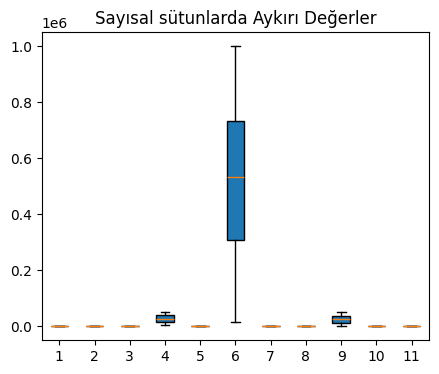

 Karakterler içerisinde boş veri yok


In [5]:
#Aykırı Değer Kontrolü
#Bu sadece sayısal değerlerde işe yarayacağı için önce veri türlerini ayır
number_column = df.select_dtypes(include=["int64", "float64"]).columns
print(number_column)
#sayısal verileri boxplot ile kontrol et.
plt.figure(figsize = (5,4))
plt.boxplot(df[number_column], patch_artist = True)
plt.title("Sayısal sütunlarda Aykırı Değerler")
plt.show()
#satırlar için boş veri kontrolü yapılır.
string_column = df.select_dtypes(include=["object"]).columns
bos_deger = string_column.isnull().any
if bos_deger == True:
    string_bos_deger = string_column[string_column.isnull().any(axis=1)]
    print(string_bos_deger)
else:
    print(" Karakterler içerisinde boş veri yok")
    


Veriyi eğitim (%80) ve test (%20) olarak ayırın.

In [6]:
#hedef belirtilmediği için tüm sütunlar veri içerisine dahil edilir
veri_seti=df  
egitim_verisi, test_verisi = train_test_split(
    veri_seti, # ayarlanmak istenen veri seti 
    test_size = 0.2, #dolayısıyla egitim verisi de %80 olur.
    random_state = 30 #her seferinde sabit bir değer almak için rastgele bir sayı
)

#boyutların kontrolü
print(f"Orijinal veri setinin boyutu : {df.shape}")
print(f"Eğitim veri setinin boyutu : {egitim_verisi.shape}")
print(f"Test veri setinin boyutu : {test_verisi.shape}")

Orijinal veri setinin boyutu : (200, 12)
Eğitim veri setinin boyutu : (160, 12)
Test veri setinin boyutu : (40, 12)


In [7]:
kategorik_sütunlar = egitim_verisi.select_dtypes(include=["object"]).columns
if len(kategorik_sütunlar) > 0 :
    print(f"Kodlanacak kategorik sütunlar : {kategorik_sütunlar.tolist()}")
else:
    print("Tüm ifadeler sayısal değer. Kodlanacak kategorik sütun yok.")

egitim_verisi = pd.get_dummies(egitim_verisi, columns = kategorik_sütunlar, drop_first = True)
test_verisi = pd.get_dummies(test_verisi, columns = kategorik_sütunlar, drop_first = True)

Kodlanacak kategorik sütunlar : ['Case Type']


In [8]:
from sklearn.cluster import KMeans 
#import pandas as pd 

#küme sayısını belirle
küme_sayisi = 3

#K-Means modelini oluşturma
kmeans = KMeans( #kmeans ile veri  noktalarını belirli sayıda(3) kümelere ayırdık
    n_clusters = küme_sayisi, #ayrılmış olan 3 grup decision tree modelinin tahmin etmeye çalışacağı hedef etiketleri oluşturur
    random_state = 30,
    n_init = "auto" # versiyon uyumluluğu için
)

#Modeli sadece eğitim veri setinde eğitir.
kmeans.fit(egitim_verisi) #modeli eğitim verisinin tümü üzerinde eğitti

#eğitim verisi için öğrenilen etiketleri kullan 
egitim_verisi["küme_etiketi"] = kmeans.labels_ #eğitim verisi için modelin atadığı küme numaraları

#test verisi için eğitilen modeli kullanarak tahmin yapıp etiket ekle.
test_verisi["küme_etiketi"] = kmeans.predict(test_verisi) #eğitilmiş modeli kullanarak test verilerinin hangi kümeye ait olduğunu bulur

print(f"K-Means ile {küme_sayisi} adet küme etiketi (0, 1, 2) oluşturuldu.")
print("Decision Tree için gerekli olan 'küme_etiketi' sütunu artık mevcut.")
print("-----------------------------------------------------------------")
print("Eğitim Verisi Etiket Dağılımı:")
print(egitim_verisi['küme_etiketi'].value_counts())

K-Means ile 3 adet küme etiketi (0, 1, 2) oluşturuldu.
Decision Tree için gerekli olan 'küme_etiketi' sütunu artık mevcut.
-----------------------------------------------------------------
Eğitim Verisi Etiket Dağılımı:
küme_etiketi
1    66
2    59
0    35
Name: count, dtype: int64


In [15]:
from sklearn.tree import DecisionTreeClassifier
x_egitim = egitim_verisi.drop("küme_etiketi", axis = 1)
y_egitim = egitim_verisi["küme_etiketi"]
x_test = test_verisi.drop("küme_etiketi", axis = 1)
y_test = test_verisi["küme_etiketi"]

#modelin oluşturulması ve hiperparametre ayarları
dtmodel = DecisionTreeClassifier ( #dt_model belirtilen sınıftan oluşturulan model listesidir
    max_depth = 5, #karar ağacının ne kadar derine ineceğini gösterir. Fazla büyük olursa overfitting yapar.
    random_state = 30
)

dtmodel.fit(x_egitim, y_egitim) #.fit() ile decision tree uygulamasını başlatırız. model, x ile y arasındaki ilişkiyi öğrenir.
#bu süreçte decision tree, veriyi en iyi şekilde bölen ve etiketleri en saf gruplara ayıran karar kurallarını bulmak için 
#veri setinin tüm özelliklerini inceler. Tüm oluşturduğu kurallar, ağacın yapısını oluşturur. 

print(" Decision Tree modeli başarıyla eğitildi")
print(f"Ağacın tahmini derinliği : {dtmodel.get_depth()}")


 Decision Tree modeli başarıyla eğitildi
Ağacın tahmini derinliği : 2


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
#test verisi  üzerinde tahmin 
y_tahmin = model.predict(x_test)

print("**************************")
print("Decision Tree Matrislerinin Hesaplanması")
print("**************************")

# accuracy hesabı
accuracy = accuracy_score(y_test, y_tahmin)
print(f"Doğruluk Matrisi Hesabı : {accuracy :.4f}")

#detaylı sınıflandırma 
print("Precision, Recall, F1-Score'u ve her sınıf için ile ortalama olarak bu değerleri hesapla.")
print(classification_report(y_test, y_tahmin))
precision = precision_score(y_test, y_tahmin, average='weighted', zero_division=0)
recall = recall_score(y_test, y_tahmin, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_tahmin, average='weighted', zero_division=0)
#precision: pozitif olarak tahmin edilen etiketlerden kaç tanesi doğru?
# recall: gerçekten o etikete sahip ürünleri ne kadar doğru tahmin etti
#F1 - Scorre : Precision + Recall harmonik ortalaması
#bu üçünü de ayrı ayrı tanımlamamız gerekiyordu. tanımlanmadıkları ve çağrılmadıkları için hata verdi

print(f"Ortalama Hassasiyet Değeri : {precision:.4f}")
print(f"Ortalama geri çağırma değeri : {recall:.4f}")
print(f"Ortalama F1 skoru : { f1:.4f}")

**************************
Decision Tree Matrislerinin Hesaplanması
**************************
Doğruluk Matrisi Hesabı : 0.9750
Precision, Recall, F1-Score'u ve her sınıf için ile ortalama olarak bu değerleri hesapla.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.92      1.00      0.96        12
           2       1.00      0.92      0.96        12

    accuracy                           0.97        40
   macro avg       0.97      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

Ortalama Hassasiyet Değeri : 0.9769
Ortalama geri çağırma değeri : 0.9750
Ortalama F1 skoru : 0.9750


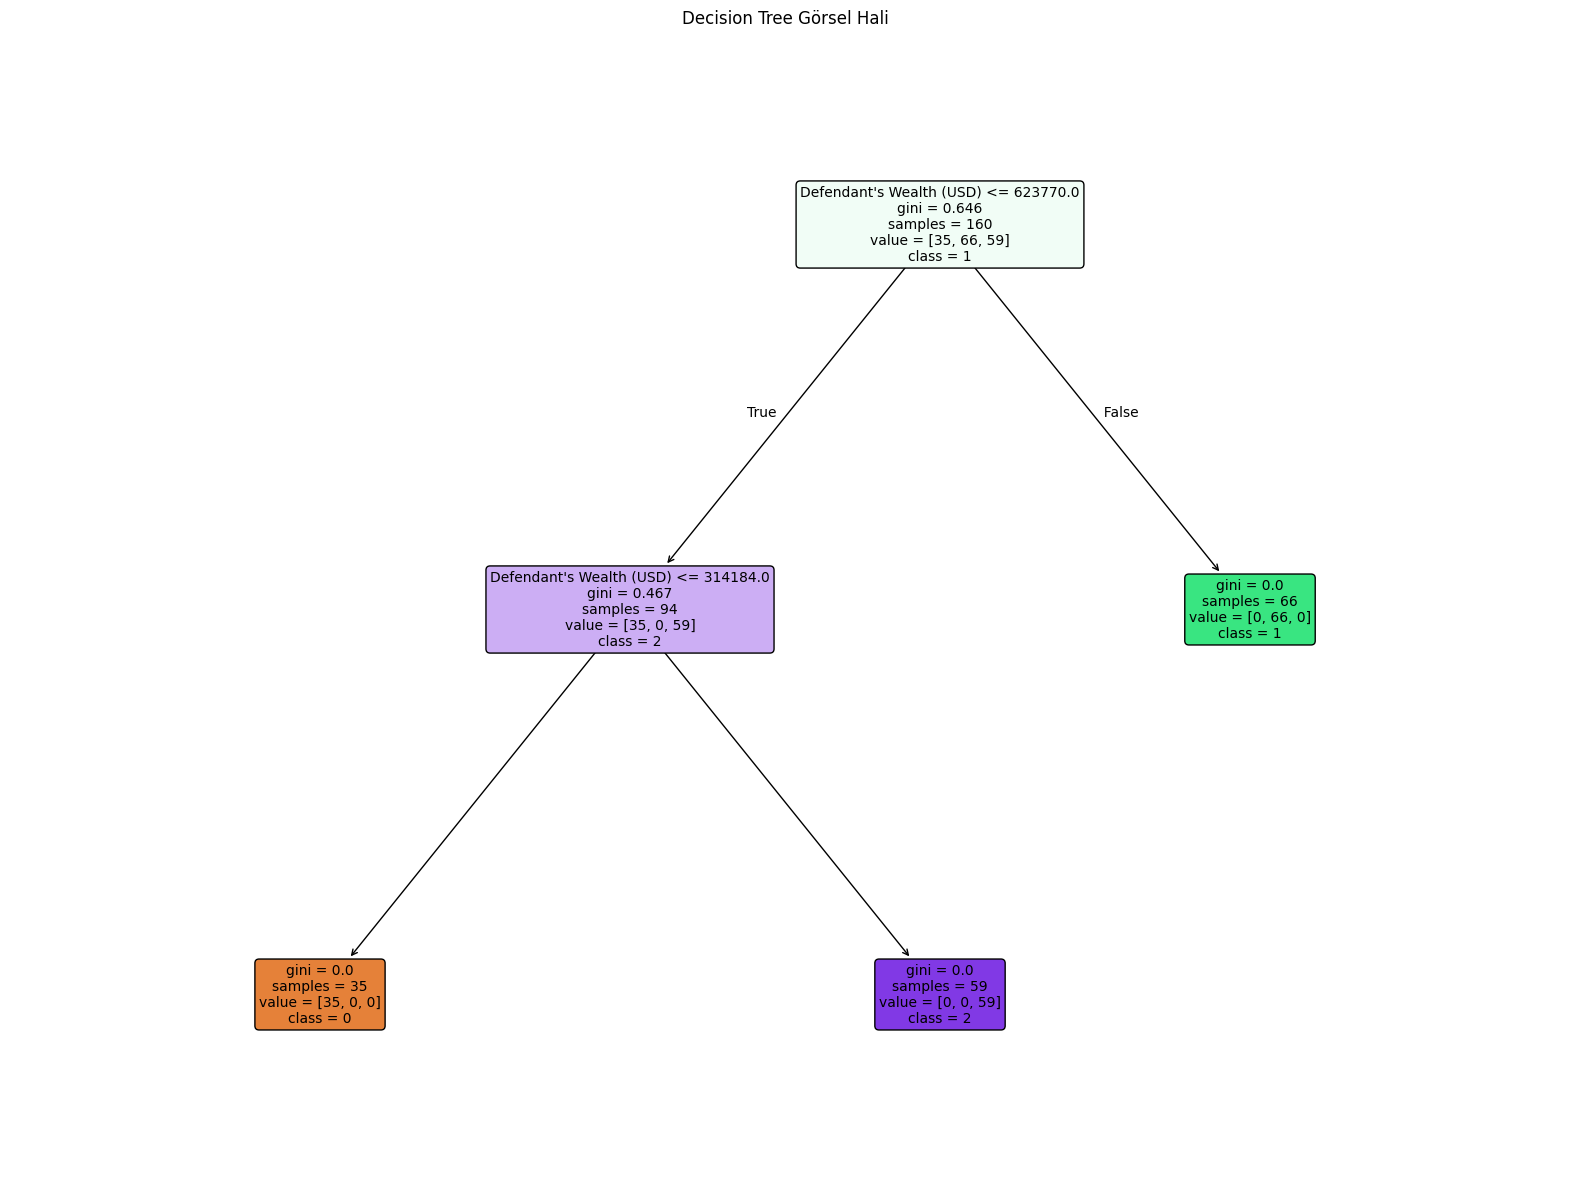

********************
Özelliklerin Önem Dereceleri
*********************
                       özellik  önem_derecesi
5     Defendant's Wealth (USD)            1.0
1     Judge Experience (Years)            0.0
2          Number of Witnesses            0.0
3             Legal Fees (USD)            0.0
0         Case Duration (Days)            0.0
4       Plaintiff's Reputation            0.0
6     Number of Evidence Items            0.0
7   Number of Legal Precedents            0.0
8     Settlement Offered (USD)            0.0
9                     Severity            0.0
10                     Outcome            0.0
11        Case Type_Commercial            0.0
12          Case Type_Criminal            0.0


In [23]:
from sklearn.tree import plot_tree
plt.figure(figsize = (20, 15)) # ağacın boyutunu ayarladık.

plot_tree( #agacın kendisini çizen fonksiyondur
    dtmodel,
    feature_names = x_egitim.columns.tolist(), #feature names : karar düğümlerinde hangi sütun isimlerinin kullanılacağını sağlar
    class_names = [str(c) for c in dtmodel.classes_],# yaprak düğümlerinde hangi küme etiketinin tahmin edildiğini gösterir
    filled = True,
    rounded = True,
    fontsize = 10
)
plt.title("Decision Tree Görsel Hali")
plt.show()

print("********************")
print("Özelliklerin Önem Dereceleri")
print("*********************")

onem_dereceleri = dtmodel.feature_importances_ # eğitilen decision tree modeli, her bir özelliğin karar verme sürecine olan katkısını söyler
ozellik_isimleri = x_egitim.columns.tolist()

onem_df = pd.DataFrame({
    "özellik" : ozellik_isimleri,
    "önem_derecesi" : onem_dereceleri
}).sort_values(by="önem_derecesi", ascending = False)

print(onem_df)
    